<a href="https://colab.research.google.com/github/1s5ac/STA365_HW/blob/main/STA365_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:241: RuntimeWarning: invalid value encountered in divide
  self.scaling = tune(self.scaling, self.accepted_sum / float(self.tune_interval))
/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


number of MCMC samples (HMC): 2000
       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  7.22  0.02    7.19     7.25        0.0      0.0   2044.31   1313.61   
phi    0.47  0.01    0.45     0.49        0.0      0.0   1850.08   1400.01   

       r_hat  
theta    1.0  
phi      1.0  
number of MCMC samples (MH): 4000
       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  6.89  1.19    4.85     7.28       0.27     0.20     49.48     28.67   
phi    0.45  0.09    0.17     0.50       0.02     0.01    100.60     31.40   

       r_hat  
theta   1.04  
phi     1.04  
number of MCMC samples (HMC): 2000
       mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.03  0.0    0.03     0.03        0.0      0.0   1024.33   1559.47   

       r_hat  
theta    1.0  
number of MCMC samples (MH): 2000
       mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.03  0.0    0.03     0.03       

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

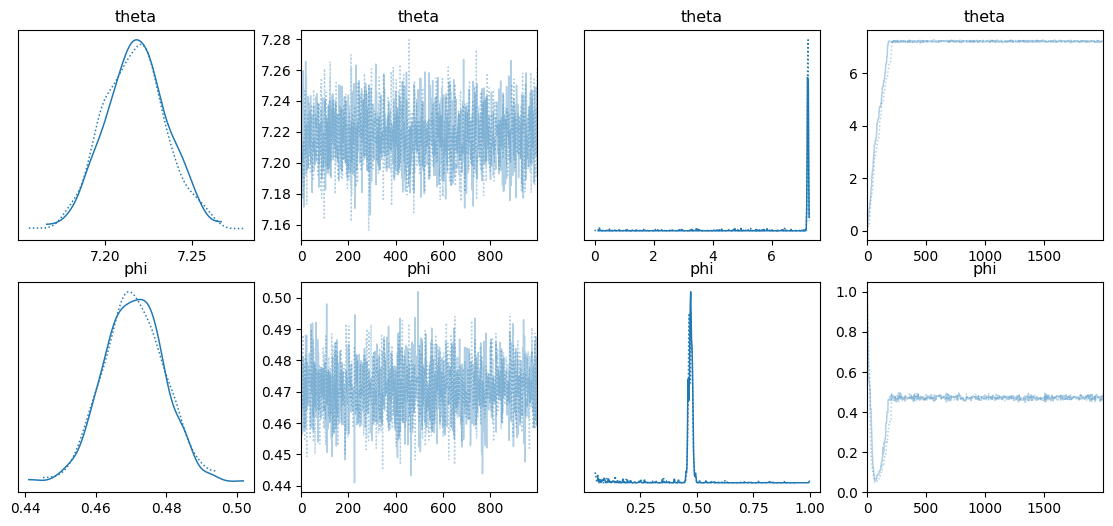

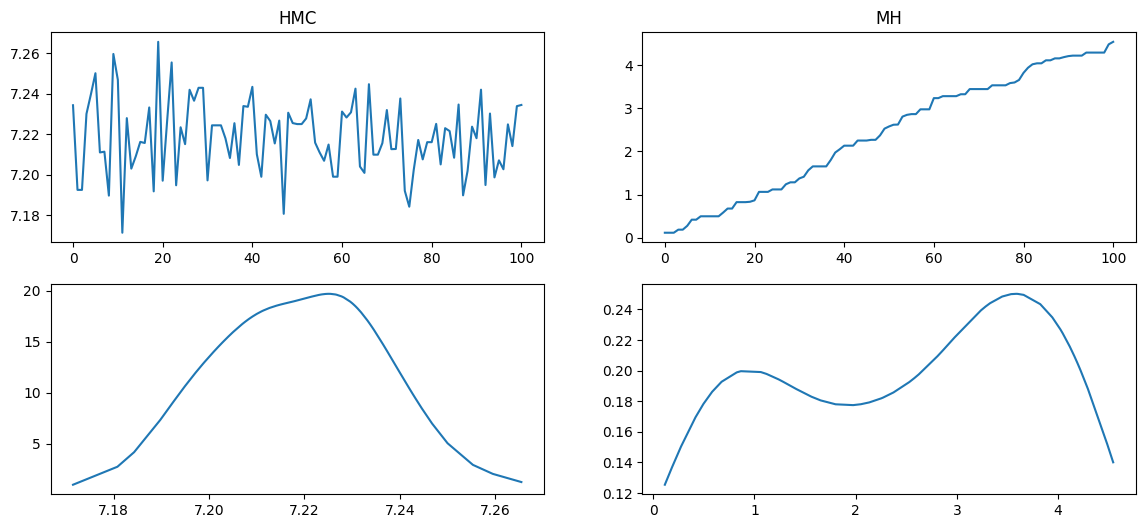

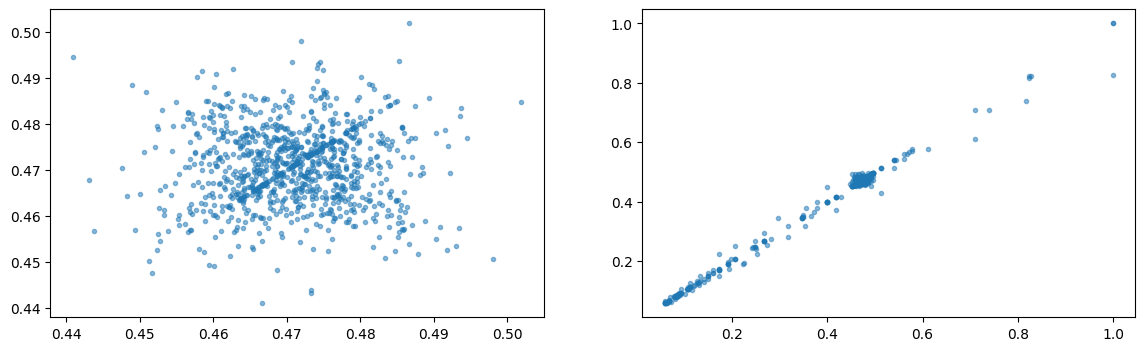

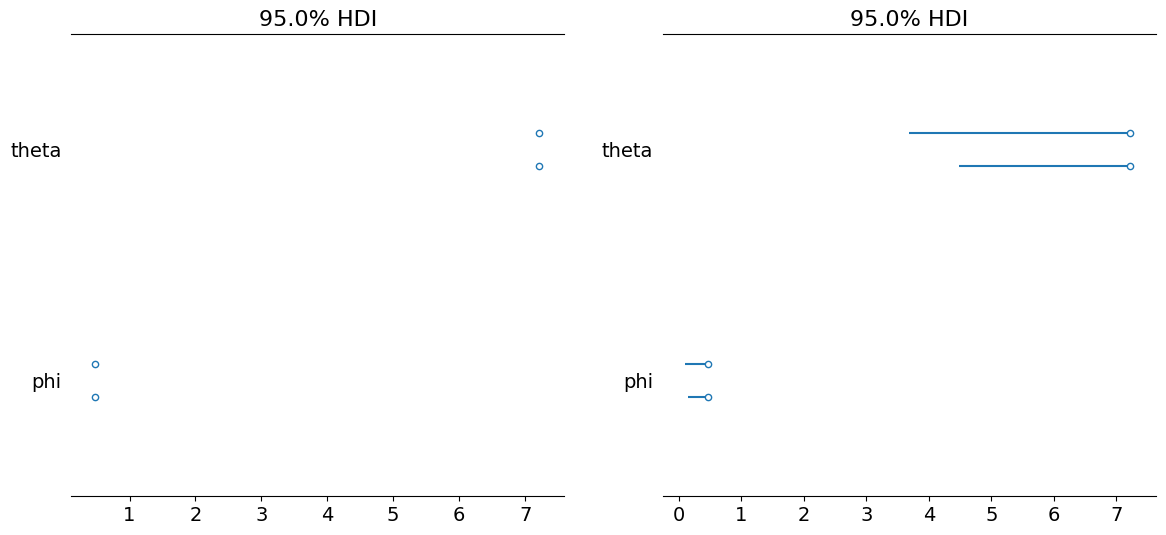

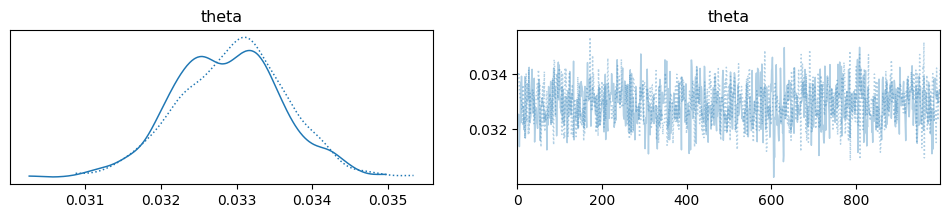

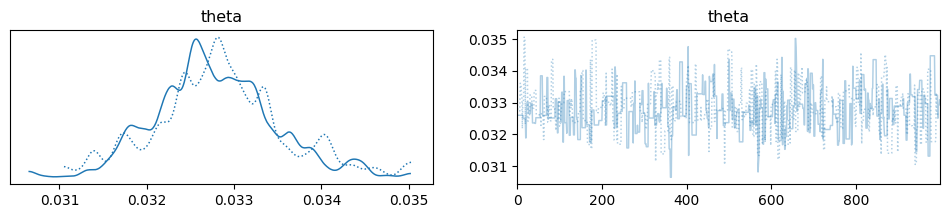

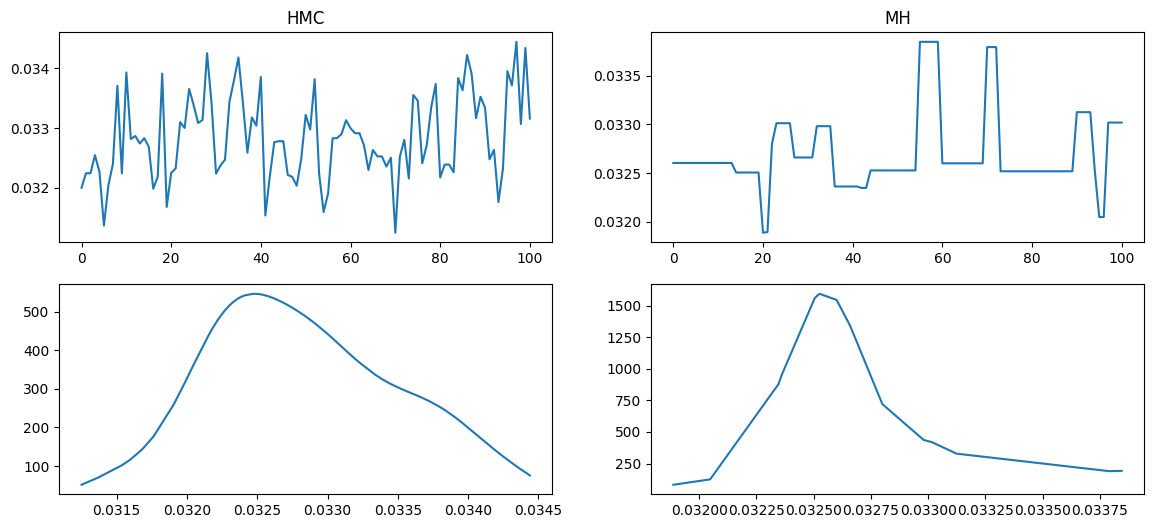

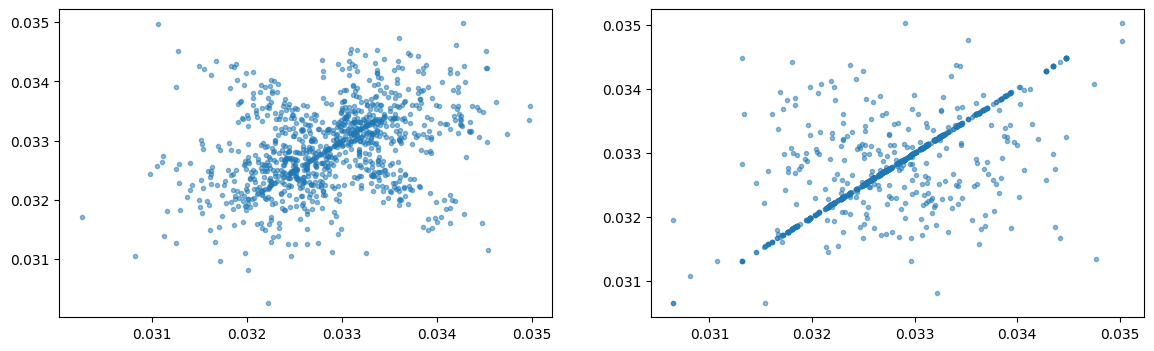

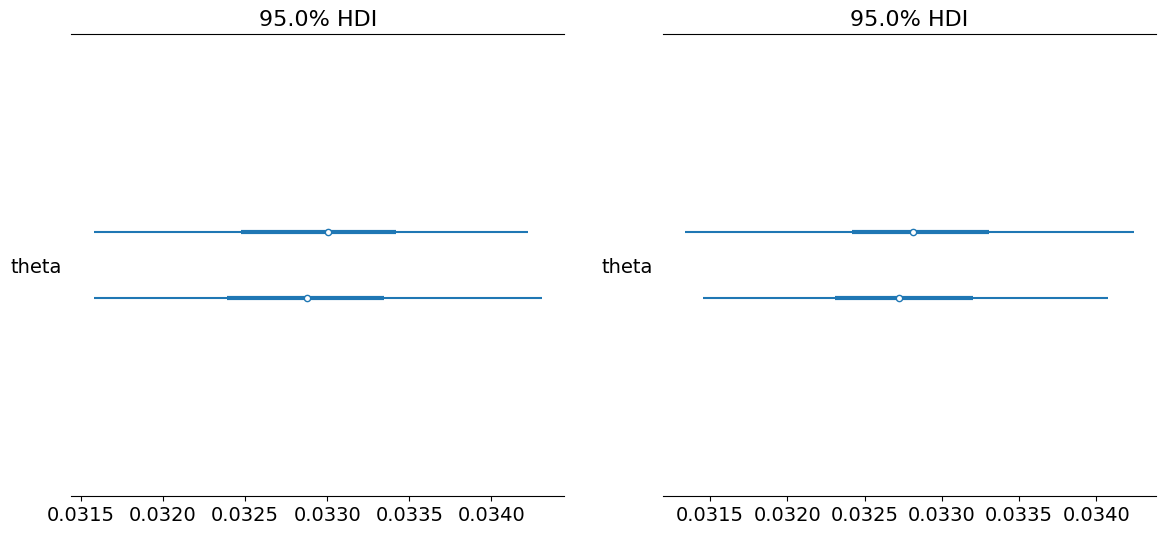

In [5]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde

# Load the dataset
url = 'https://raw.githubusercontent.com/1s5ac/STA365_HW/main/vgchartz-2024.csv'
data = pd.read_csv(url)

# Prepare data for normal-gamma model: use critic_score column and drop NaN values
critic_scores = data['critic_score'].dropna().values

# Bayesian model definition for normal-gamma model
with pm.Model() as normal_gamma_toy_model:
    # Priors for unknown model parameters
    theta = pm.Normal("theta", mu=0, sigma=1)
    phi = pm.Gamma("phi", alpha=1, beta=1)

    # Likelihood (sampling distribution) of observations
    x_obs = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5, observed=critic_scores)

    # MCMC Sampling using Hamiltonian Monte Carlo (HMC)
    idata_HMC_normal_gamma = pm.sample()

    # MCMC Sampling using Metropolis-Hastings (MH)
    MH = pm.Metropolis([theta, phi], S=np.array([0.1]), tune=False, tune_interval=0)
    idata_MH_normal_gamma = pm.sample(step=MH)

# Create a binary variable from critic_score for beta-binomial model
data['high_score'] = (data['critic_score'] > 8.0).astype(int)
binary_data = data['high_score'].dropna().values

# Bayesian model definition for beta-binomial model
with pm.Model() as beta_binomial_toy_model:
    theta = pm.Beta("theta", alpha=1, beta=1)
    x_obs = pm.Binomial("likelihood", n=1, p=theta, observed=binary_data)

    # MCMC Sampling using Hamiltonian Monte Carlo (HMC)
    idata_HMC_beta_binomial = pm.sample()

    # MCMC Sampling using Metropolis-Hastings (MH)
    MH = pm.Metropolis([theta], S=np.array([0.1]), tune=False, tune_interval=0)
    idata_MH_beta_binomial = pm.sample(step=MH)

# Visualization and Analysis for normal-gamma model
fig, ax = plt.subplots(2, 4, figsize=(14, 6))
az.plot_trace(idata_HMC_normal_gamma, axes=ax[:, :2])
az.plot_trace(idata_MH_normal_gamma, axes=ax[:, 2:])

# Additional plots and analysis for normal-gamma model
fig, ax = plt.subplots(2, 2, figsize=(14, 6))
n_mcmc_samples = 100
mcmc_chain = idata_HMC_normal_gamma.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values
mcmc_chain_sorted = sorted(mcmc_chain)
ax[0, 0].plot(mcmc_chain)
ax[1, 0].plot(mcmc_chain_sorted, gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted))
ax[0, 0].set_title("HMC")

mcmc_chain = idata_MH_normal_gamma.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values
mcmc_chain_sorted = sorted(mcmc_chain)
ax[0, 1].plot(mcmc_chain)
ax[1, 1].plot(mcmc_chain_sorted, gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted))
ax[0, 1].set_title("MH")

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
max_mcmc_samples = 1000
mcmc_chain = idata_HMC_normal_gamma.posterior["phi"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values
mcmc_chain_one_step_ahead = idata_HMC_normal_gamma.posterior["phi"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values
ax[0].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)

mcmc_chain = idata_MH_normal_gamma.posterior["phi"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values
mcmc_chain_one_step_ahead = idata_MH_normal_gamma.posterior["phi"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values
ax[1].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)

print("number of MCMC samples (HMC):", idata_HMC_normal_gamma.posterior['phi'].values.flatten().shape[-1])
print(az.summary(idata_HMC_normal_gamma, round_to=2))

print("number of MCMC samples (MH):", idata_MH_normal_gamma.posterior['phi'].values.flatten().shape[-1])
print(az.summary(idata_MH_normal_gamma, round_to=2))

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
az.plot_forest(idata_HMC_normal_gamma, var_names=["theta", "phi"], combined=False, hdi_prob=0.95, ax=ax[0])
az.plot_forest(idata_MH_normal_gamma, var_names=["theta", "phi"], combined=False, hdi_prob=0.95, ax=ax[1])

# Visualization and Analysis for beta-binomial model
az.plot_trace(idata_HMC_beta_binomial); az.plot_trace(idata_MH_beta_binomial)

# Additional plots and analysis for beta-binomial model
# Kernel density estimates
fig, ax = plt.subplots(2, 2, figsize=(14, 6))
n_mcmc_samples = 100
mcmc_chain = idata_HMC_beta_binomial.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values
mcmc_chain_sorted = sorted(mcmc_chain)
ax[0, 0].plot(mcmc_chain)
ax[1, 0].plot(mcmc_chain_sorted, gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted))
ax[0, 0].set_title("HMC")

mcmc_chain = idata_MH_beta_binomial.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values
mcmc_chain_sorted = sorted(mcmc_chain)
ax[0, 1].plot(mcmc_chain)
ax[1, 1].plot(mcmc_chain_sorted, gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted))
ax[0, 1].set_title("MH")

# Autocorrelation plots
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
max_mcmc_samples = 1000
mcmc_chain = idata_HMC_beta_binomial.posterior["theta"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values
mcmc_chain_one_step_ahead = idata_HMC_beta_binomial.posterior["theta"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values
ax[0].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)

mcmc_chain = idata_MH_beta_binomial.posterior["theta"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values
mcmc_chain_one_step_ahead = idata_MH_beta_binomial.posterior["theta"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values
ax[1].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)

# Summary statistics
print("number of MCMC samples (HMC):", idata_HMC_beta_binomial.posterior['theta'].values.flatten().shape[-1])
print(az.summary(idata_HMC_beta_binomial, round_to=2))

print("number of MCMC samples (MH):", idata_MH_beta_binomial.posterior['theta'].values.flatten().shape[-1])
print(az.summary(idata_MH_beta_binomial, round_to=2))

# Forest plots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
az.plot_forest(idata_HMC_beta_binomial, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[0])
az.plot_forest(idata_MH_beta_binomial, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[1])


I used chatgpt in this assignment to help me debug and point out what code I could integrate and optimize to be more concise.